In [1]:
# Imports (External)
import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import copy

import sys
sys.path.append('../')  

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec, waverec
from scipy import signal
from statsmodels.robust import mad

# Internal Imports
from wsae_lstm.utils import dictmap_load,pickle_load,pickle_save,dictmap_datetime

In [2]:
#plt.rcParams["figure.figsize"] = (10,6)

In [3]:
dict_dataframes_index=pickle_load(path_filename="../data/interim/cdii_tvt_split.pickle")
dict_dataframes_index.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [4]:
# [index data][period 1-24][train/validate/test]
    # Train [1], Validate [2], Test [3]
dict_dataframes_index['csi300 index data'][1][1].head(2)

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
date,,,,,,,,,,,,,,,,,,,
2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08


In [5]:
len(dict_dataframes_index['csi300 index data'][1][1])

489

In [6]:
len(dict_dataframes_index['csi300 index data'][1][1].columns)

19

In [7]:
data = dict_dataframes_index['csi300 index data'][1][1]
data.shape[1]

19

In [8]:
# # Multi-level wavelet transform
#     # https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#pywt.wavedec
# w = pywt.Wavelet('haar')
# coeffs = wavedec(data, w, level=2,axis=0)
# cA2, cD2, cD1 = coeffs
# # cA = Approximation coefficients
#     # Approximation (low pass)
# # cD = Detail coefficient(s)
#     # Detail (high pass)
#     # Detail cofficients represent the high freq part of the signal  

In [9]:
# http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
# https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes
# https://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html

def waveletSmooth( x, wavelet="haar", level=2, declevel=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode='periodization',level=declevel,axis=0 )
    # calculate a threshold
    sigma = mad(coeff[-level])
    #print(sigma)
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="hard" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode='periodization',axis=0 )
    return y

In [10]:
################################################################################################

In [11]:
#dict_dataframes_index.keys()

In [12]:
# [index data][period 1-24][train/validate/test]
    # Train [1], Validate [2], Test [3]
dict_dataframes_index['csi300 index data'][1][1].head(2)

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
date,,,,,,,,,,,,,,,,,,,
2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08


In [13]:
for key, value in enumerate(dict_dataframes_index):
    print(value)

csi300 index data
nifty 50 index data
hangseng index data
nikkei 225 index data
s&p500 index data
djia index data


In [14]:
def denoise_periods(dict_dataframes):
    ddi_denoised= dict() 
    for key, index_name in enumerate(dict_dataframes):
        ddi_denoised[index_name] = dict_dataframes[index_name]
    for key, index_name in enumerate(ddi_denoised):    
        for index,value in enumerate(ddi_denoised[index_name]):
            ddi_denoised[index_name][value][1]=  pd.DataFrame(waveletSmooth(ddi_denoised[index_name][value][1]))
            ddi_denoised[index_name][value][2] = pd.DataFrame(waveletSmooth(ddi_denoised[index_name][value][2]))
            ddi_denoised[index_name][value][3] = pd.DataFrame(waveletSmooth(ddi_denoised[index_name][value][3]))
    return ddi_denoised



In [16]:
ddi_denoised=denoise_periods(dict_dataframes_index)


In [17]:
ddi_denoised['nifty 50 index data'][1][1].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,8.7060
1,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,7.7300
2,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.4000
3,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.2100
4,4044.3125,4125.1375,3999.8375,4084.4625,1.379709e+08,-186.6025,-63.0350,126.2125,4261.5575,4238.051979,4024.3375,4066.0550,42.6375,-242.8625,-5.509476,-0.032796,-3.901630e+08,72.6875,9.0375


In [18]:
ddi_denoised['nifty 50 index data'][1][1].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,8.7060
1,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,7.7300
2,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.4000
3,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.2100
4,4044.3125,4125.1375,3999.8375,4084.4625,1.379709e+08,-186.6025,-63.0350,126.2125,4261.5575,4238.051979,4024.3375,4066.0550,42.6375,-242.8625,-5.509476,-0.032796,-3.901630e+08,72.6875,9.0375


In [19]:
dict_dataframes_index['nifty 50 index data'][1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 19 columns):
0     490 non-null float64
1     490 non-null float64
2     490 non-null float64
3     490 non-null float64
4     490 non-null float64
5     490 non-null float64
6     490 non-null float64
7     490 non-null float64
8     490 non-null float64
9     490 non-null float64
10    490 non-null float64
11    490 non-null float64
12    490 non-null float64
13    490 non-null float64
14    490 non-null float64
15    490 non-null float64
16    490 non-null float64
17    490 non-null float64
18    490 non-null float64
dtypes: float64(19)
memory usage: 72.8 KB


In [20]:
dict_dataframes_index['nifty 50 index data'][1][1].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,8.7060
1,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,7.7300
2,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.4000
3,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.2100
4,4044.3125,4125.1375,3999.8375,4084.4625,1.379709e+08,-186.6025,-63.0350,126.2125,4261.5575,4238.051979,4024.3375,4066.0550,42.6375,-242.8625,-5.509476,-0.032796,-3.901630e+08,72.6875,9.0375


In [21]:
pickle_save(ddi_denoised,path_filename="../data/interim/cdii_tvt_split_denoised")

In [22]:
ddi_denoised=pickle_load(path_filename="../data/interim/cdii_tvt_split_denoised.pickle")

In [23]:
len(ddi_denoised)

6

In [24]:
ddi_denoised.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [26]:
ddi_denoised['nifty 50 index data'][1][1].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,8.7060
1,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,7.7300
2,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.4000
3,3989.0750,4078.3500,3874.4250,3982.9625,1.677521e+08,-204.3850,-138.1425,203.9250,4364.1550,4336.526555,4059.5525,4179.5225,-273.5375,-598.2875,-13.050589,-0.099141,-6.660193e+08,72.4425,6.2100
4,4044.3125,4125.1375,3999.8375,4084.4625,1.379709e+08,-186.6025,-63.0350,126.2125,4261.5575,4238.051979,4024.3375,4066.0550,42.6375,-242.8625,-5.509476,-0.032796,-3.901630e+08,72.6875,9.0375


In [27]:
from matplotlib.backends.backend_pdf import PdfPages
# create a PdfPages object


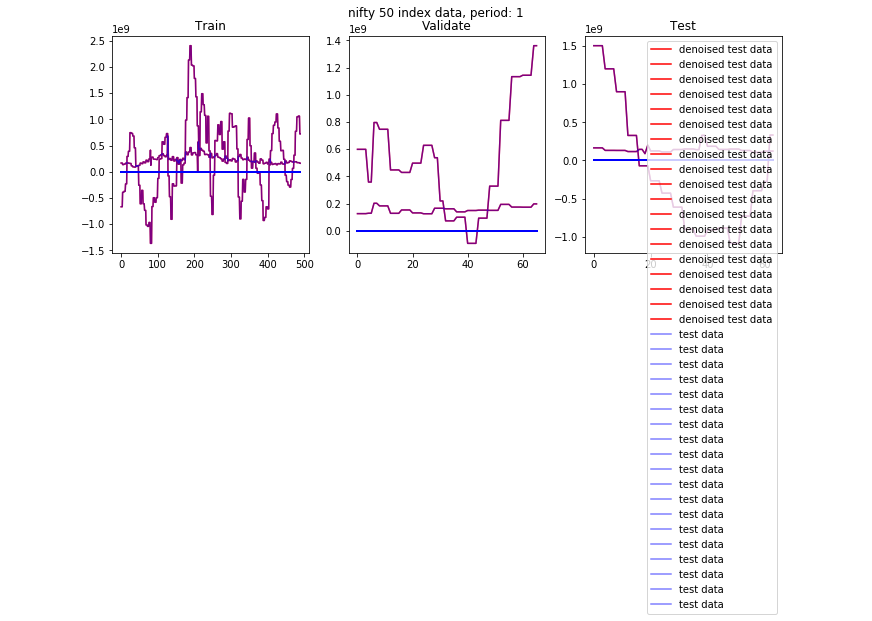

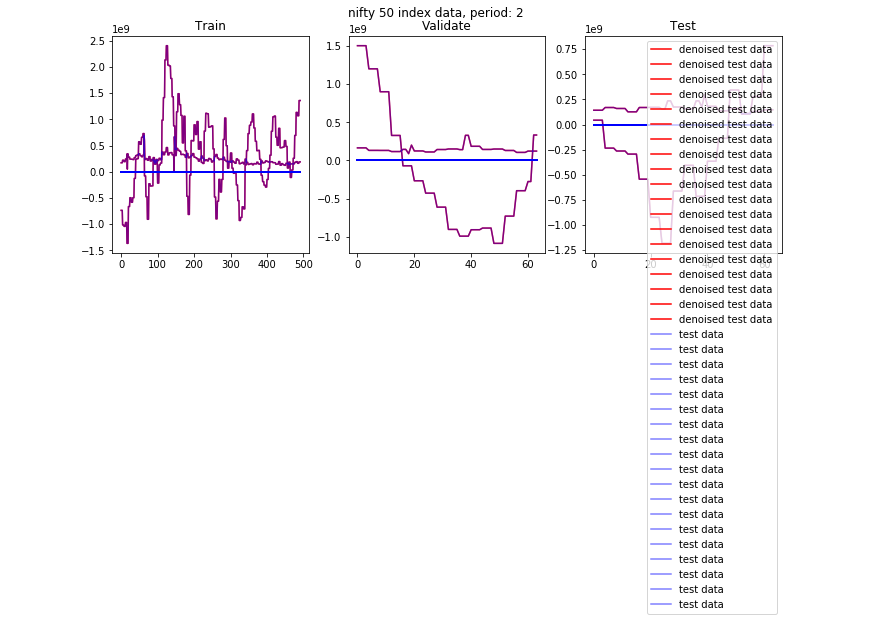

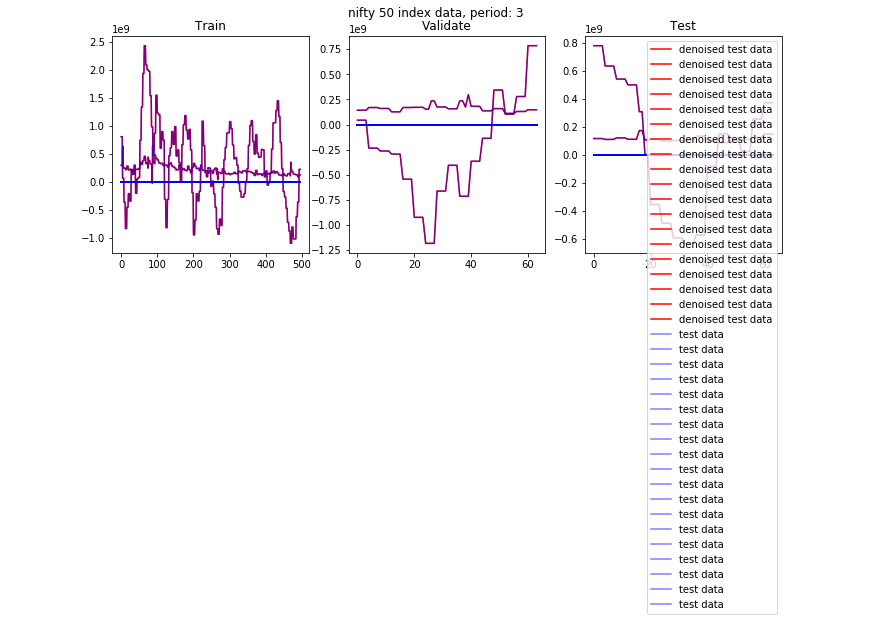

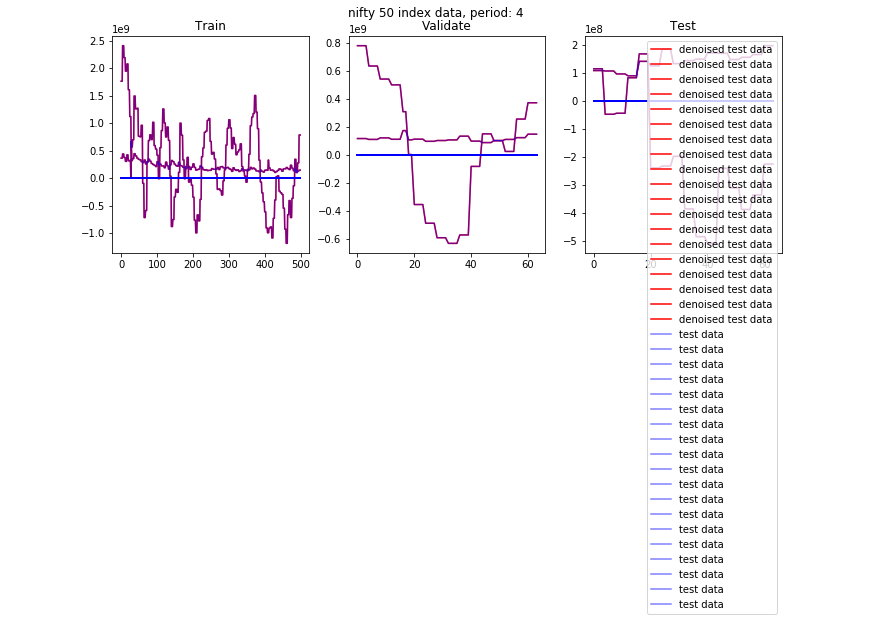

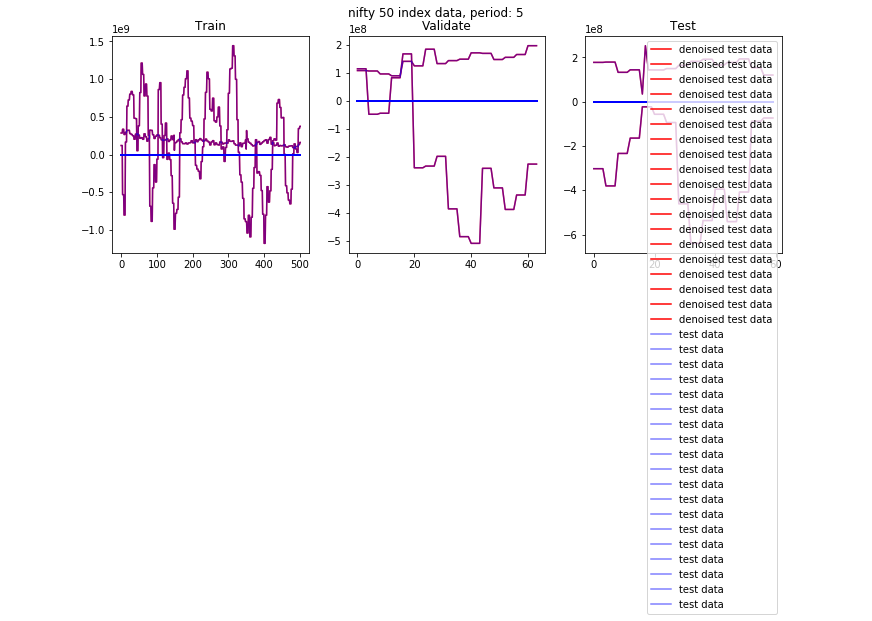

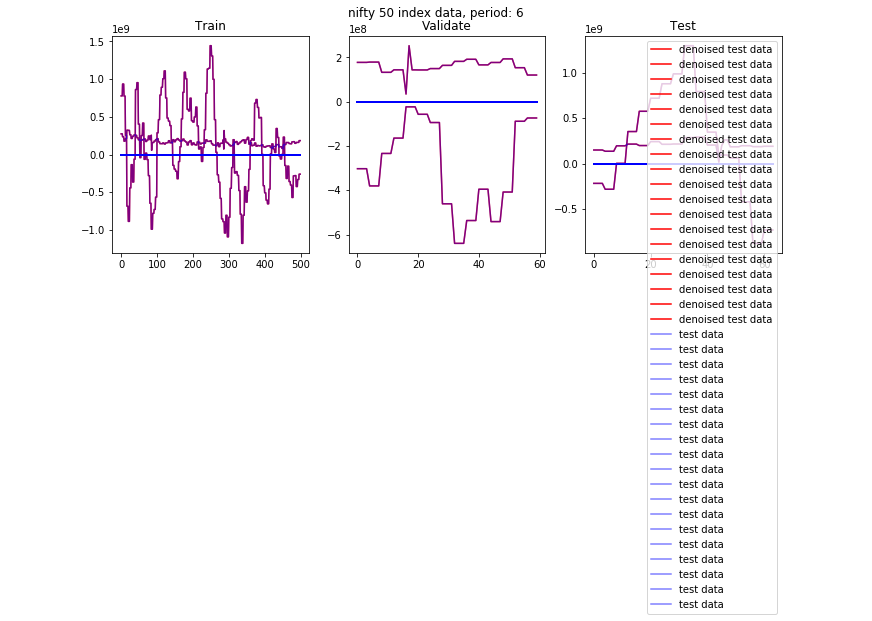

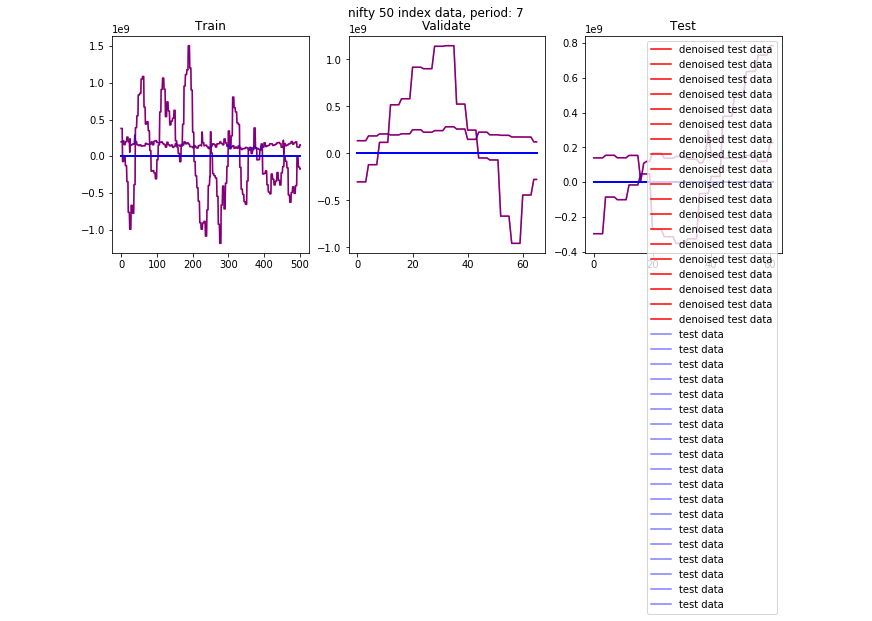

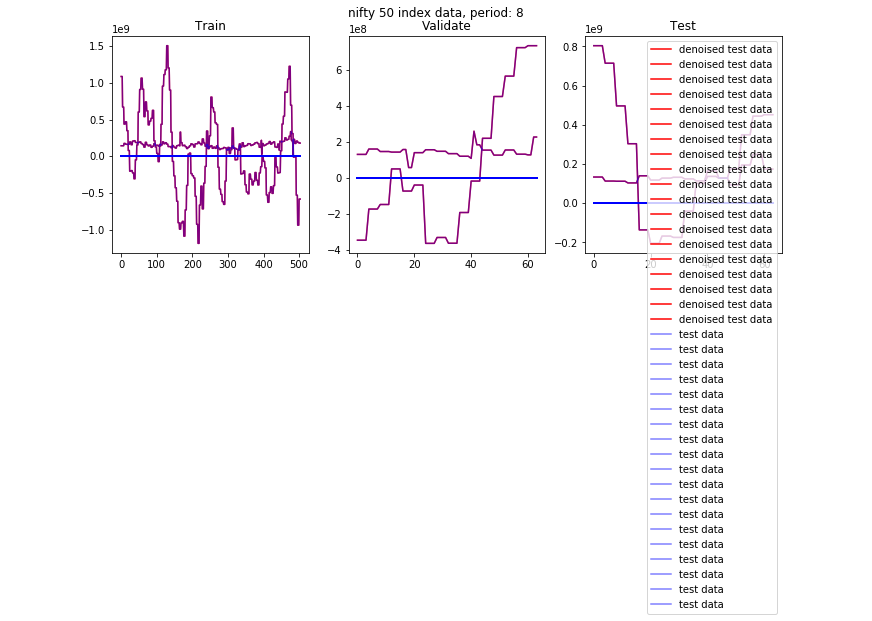

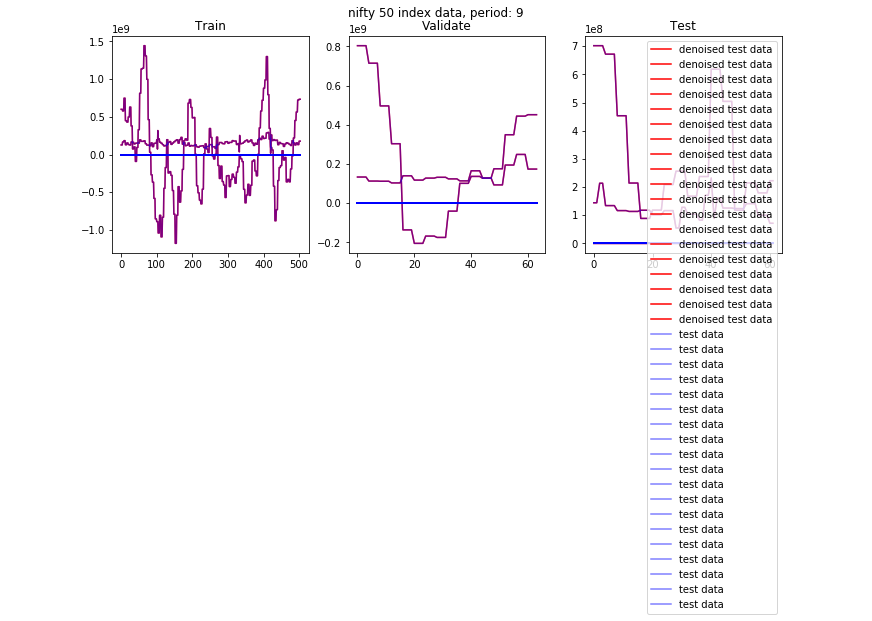

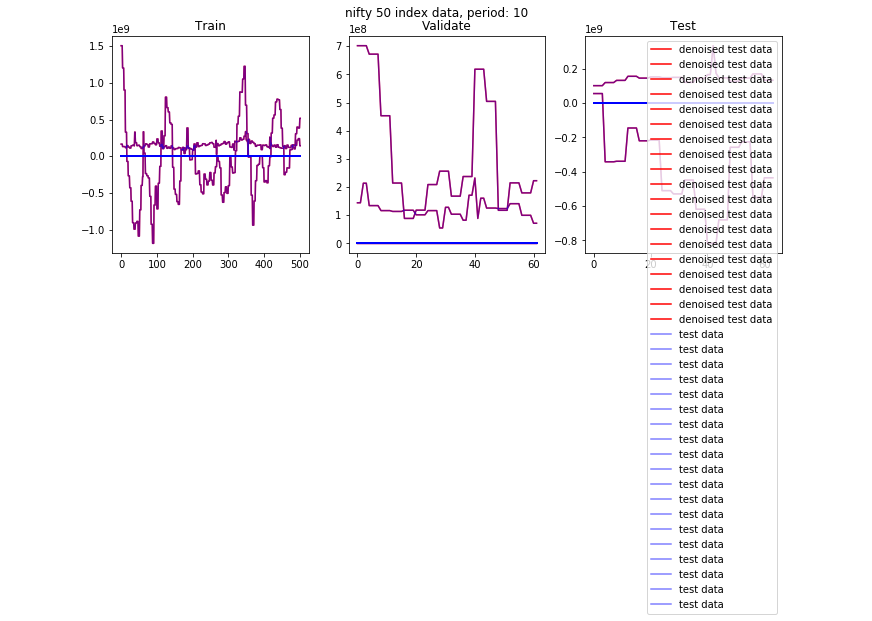

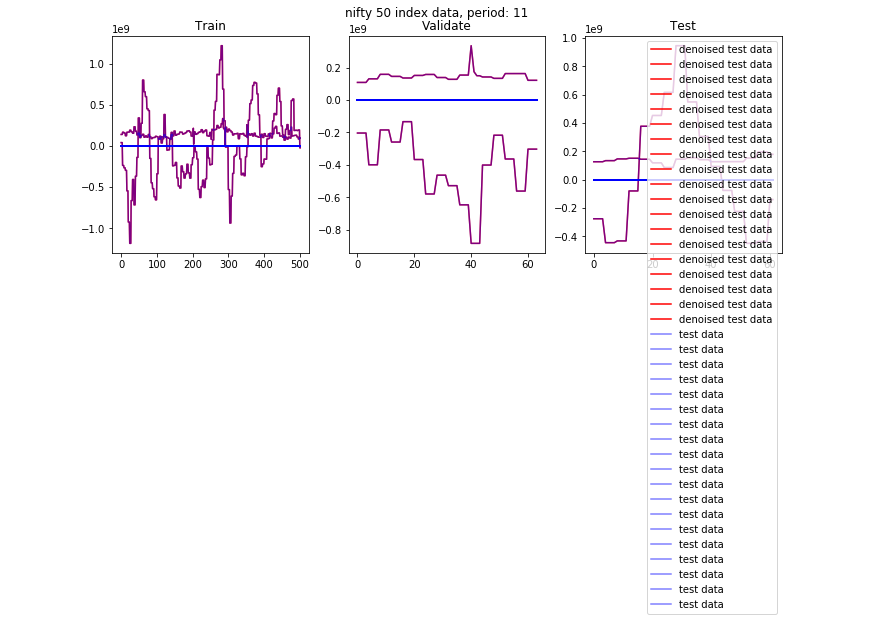

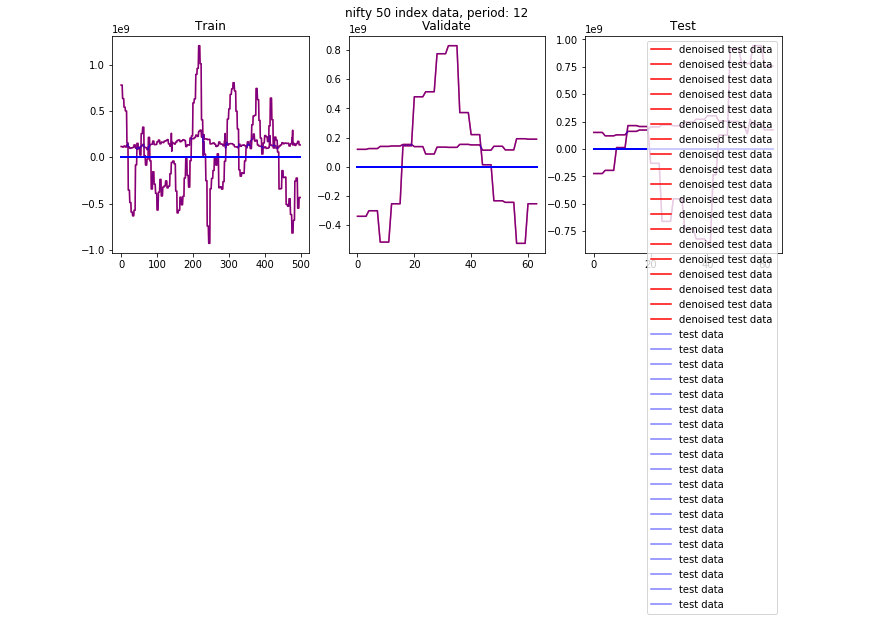

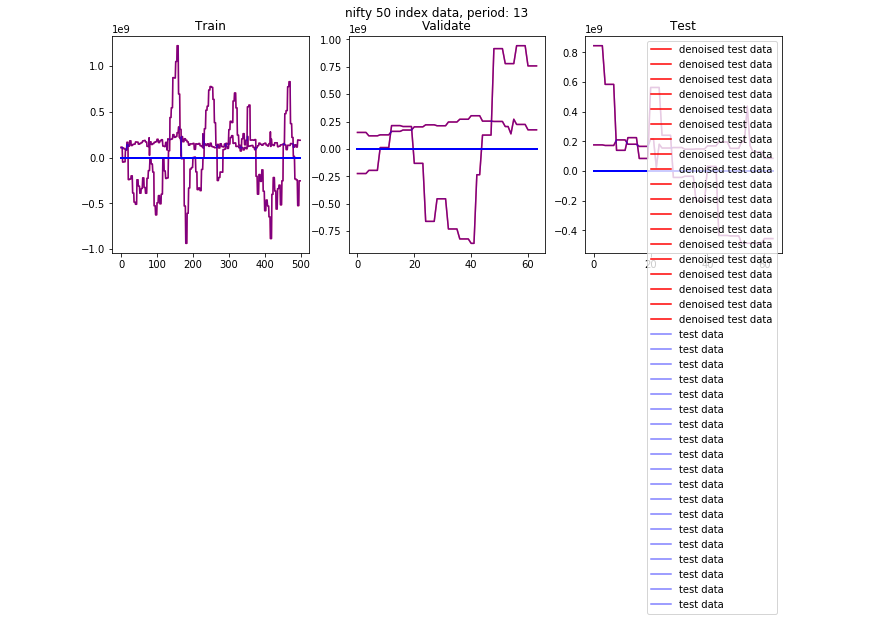

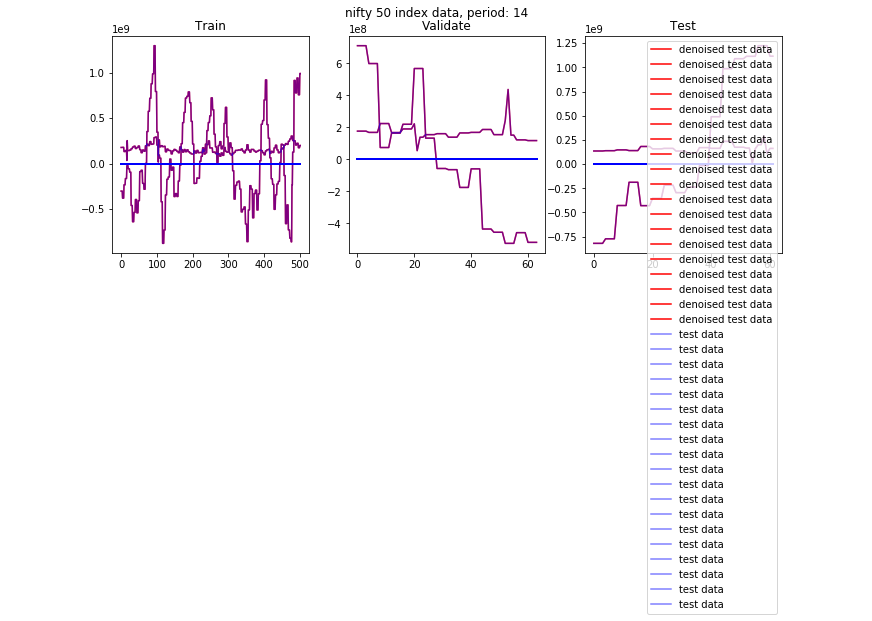

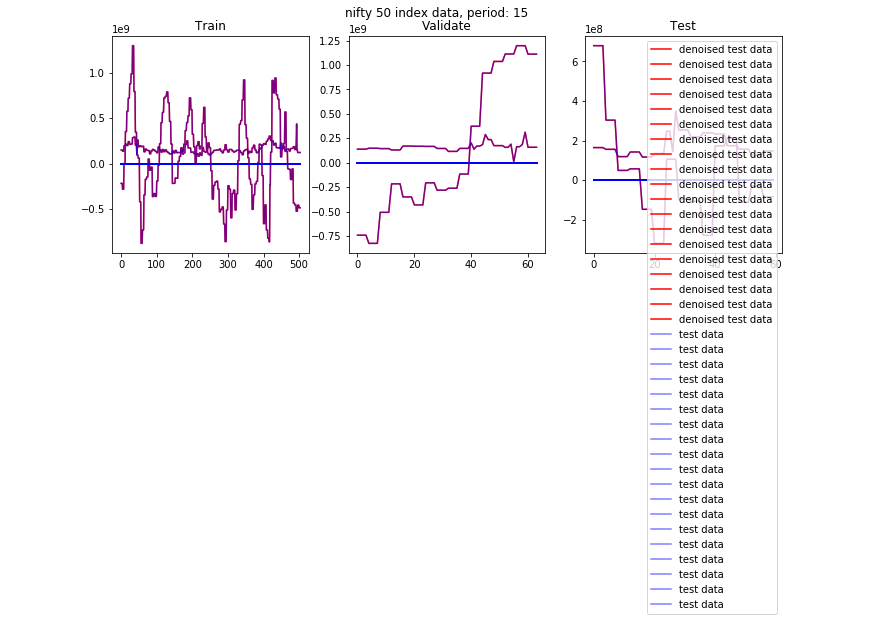

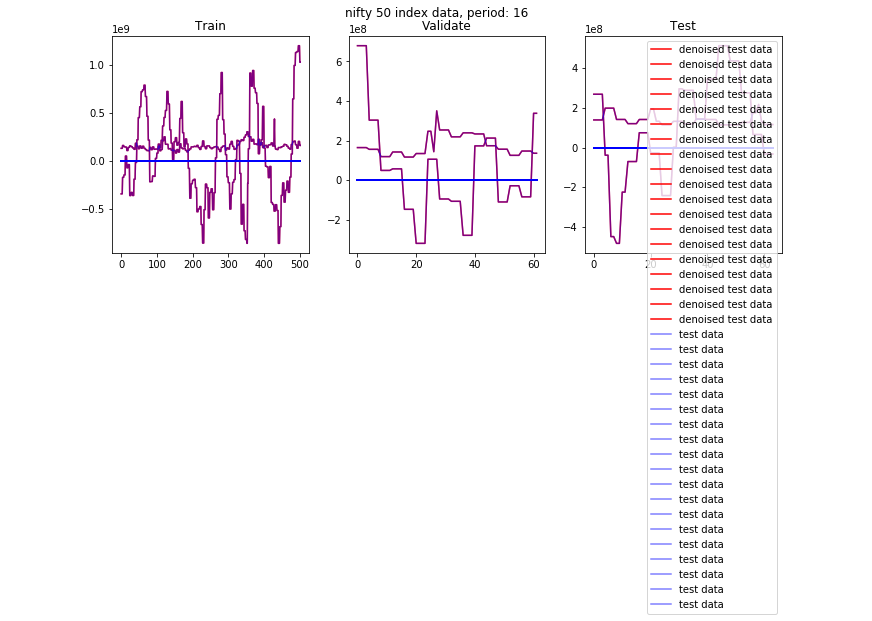

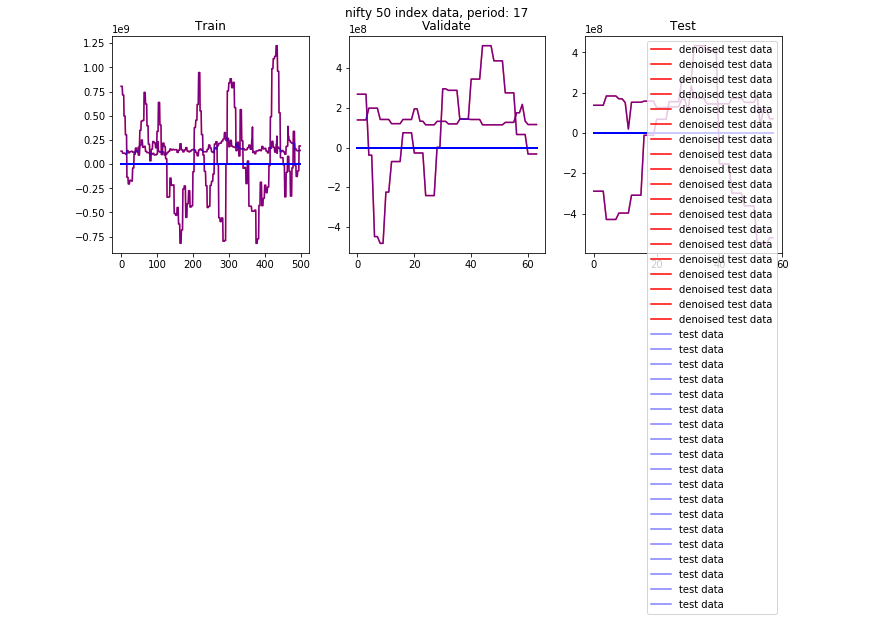

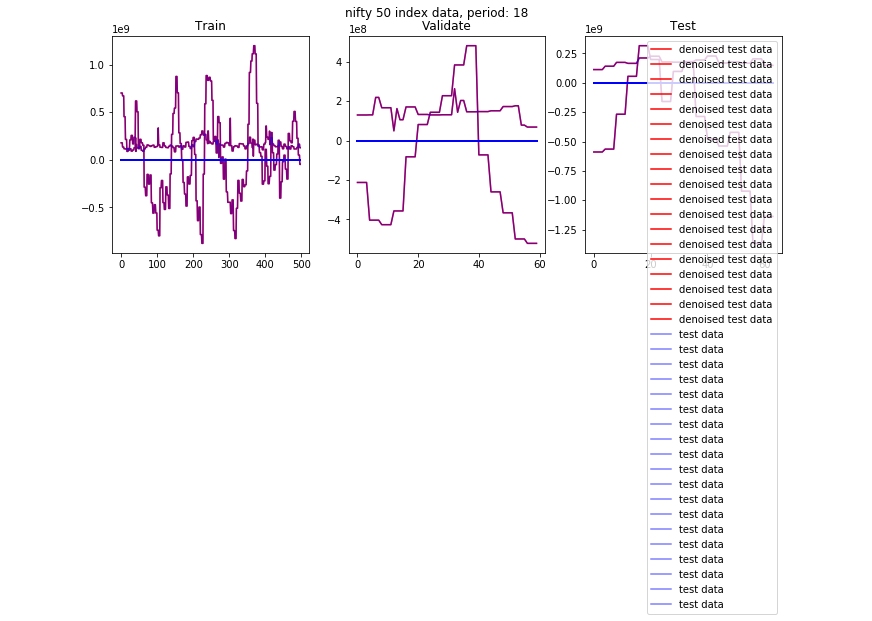

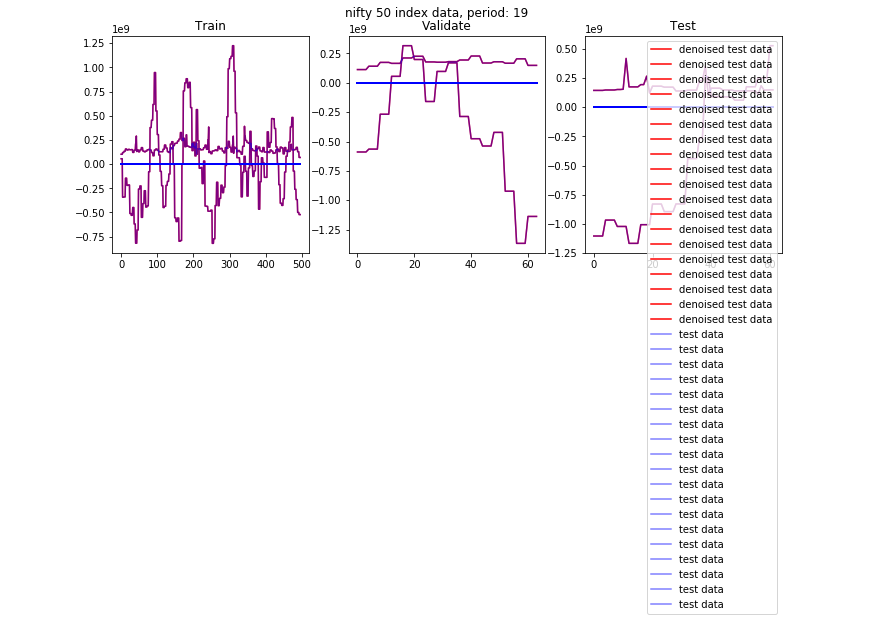

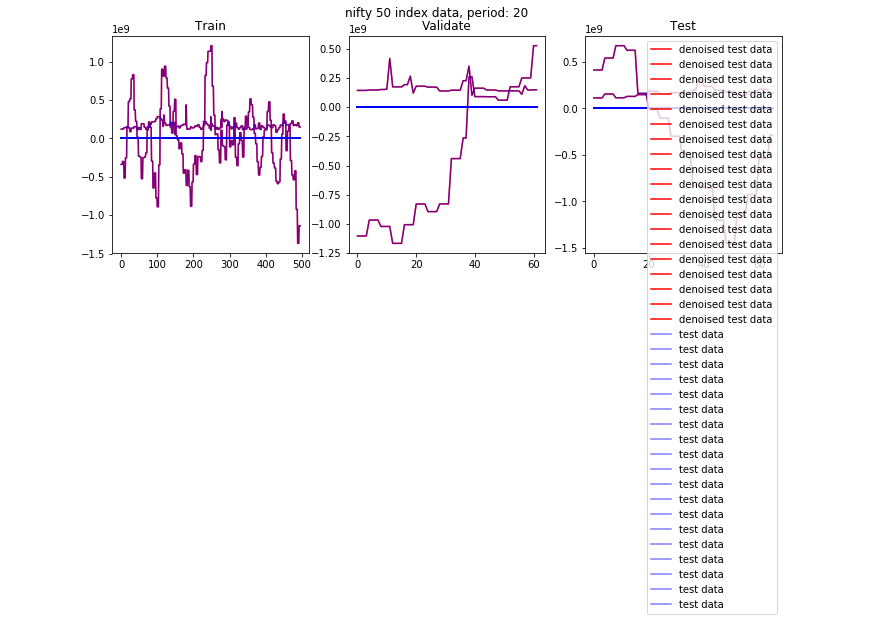

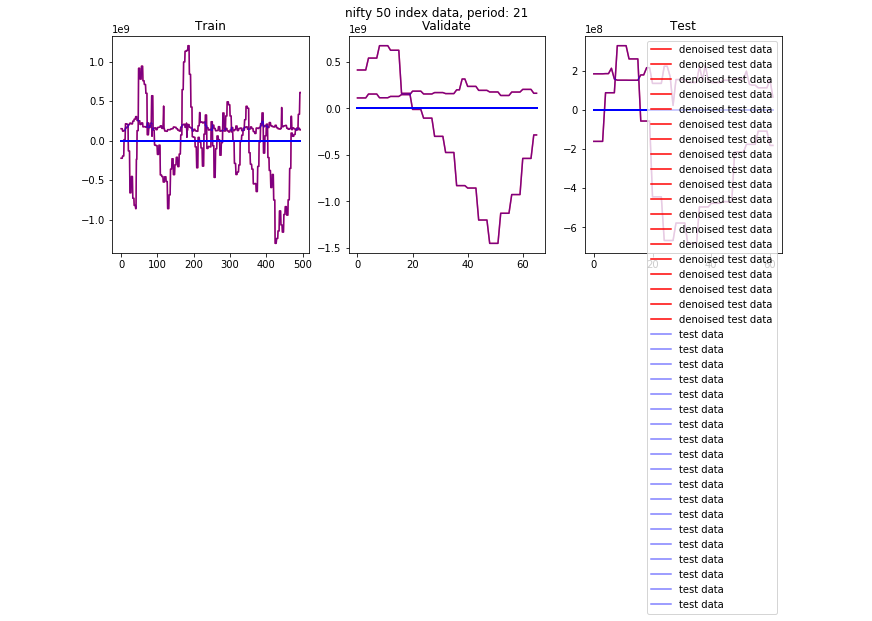

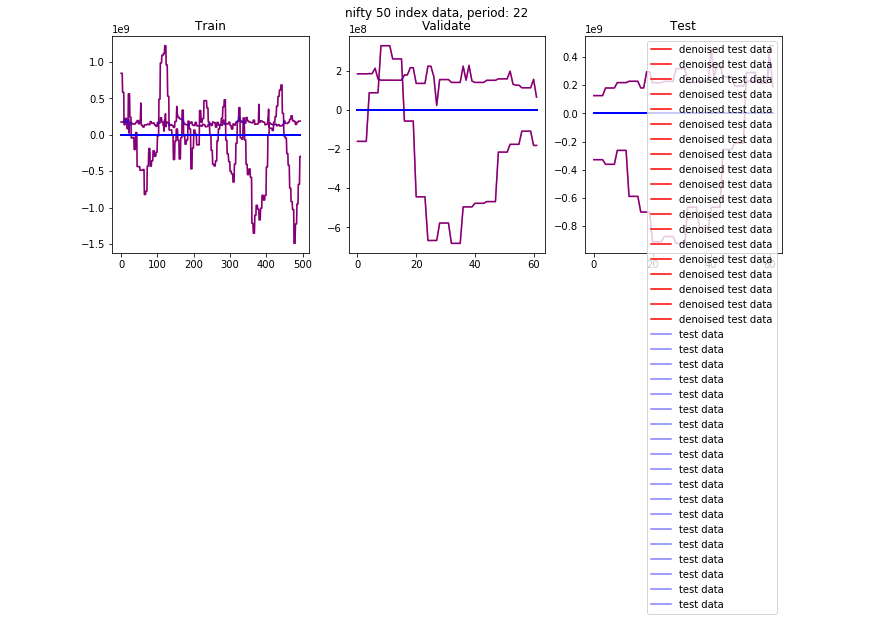

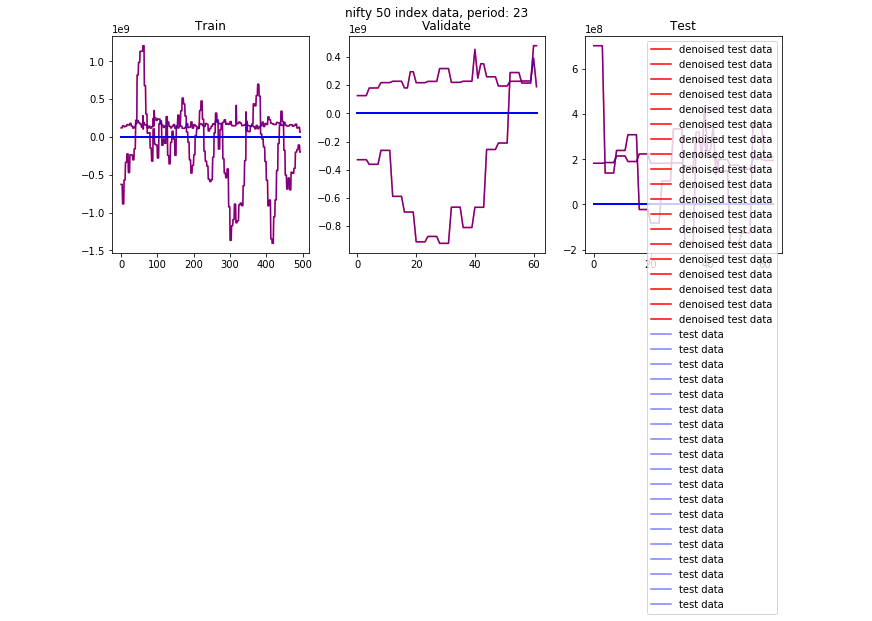

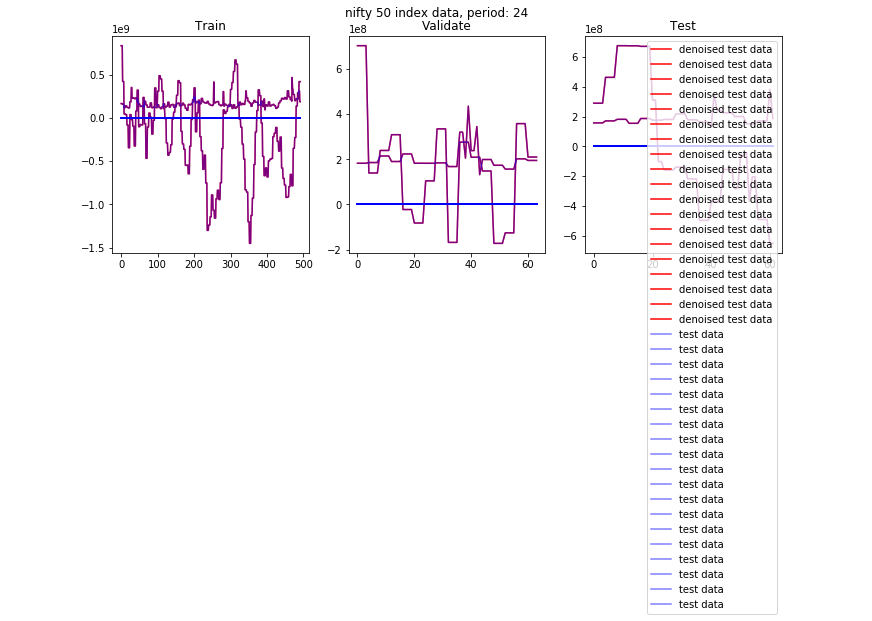

In [28]:
#%%capture
#pdf = PdfPages('nifty 50 index data tvt split denoise visual.pdf')
for index,value in enumerate(dict_dataframes_index['nifty 50 index data']): 
    #print("Period:",value)
    
    fig, axes= plt.subplots(1, 3,constrained_layout=True,figsize=(12,4))
 
    fig.suptitle('nifty 50 index data, period: {}'.format(value))
    fig.subplots_adjust(top=0.88)
    
    axes[0].set_title('Train')
    axes[0].plot(ddi_denoised['nifty 50 index data'][value][1],'r',label='denoised train data');
    axes[0].plot(dict_dataframes_index['nifty 50 index data'][value][1].values,'b',alpha=0.5, label='train data');

    axes[1].set_title('Validate')
    axes[1].plot(ddi_denoised['nifty 50 index data'][value][2],'r',label='denoised validate data');
    axes[1].plot(dict_dataframes_index['nifty 50 index data'][value][2].values,'b',alpha=0.5,label='validate data');

    axes[2].set_title('Test')
    axes[2].plot(ddi_denoised['nifty 50 index data'][value][3],'r',label='denoised test data');
    axes[2].plot(dict_dataframes_index['nifty 50 index data'][value][3].values,'b',alpha=0.5,label='test data');
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.legend()
    #plt.tight_layout()
    plt.show()
    #pdf.savefig(fig)
#pdf.close()



In [ ]:
# %%capture
# def tvt_display(ddi_denoised):
#     for key, index_name in enumerate(ddi_denoised):
#         pdf = PdfPages('{} tvt split denoise visual.pdf'.format(index_name))
#         for index,value in enumerate(dict_dataframes_index[index_name]): 
#             fig, axes= plt.subplots(1, 3,constrained_layout=True,figsize=(12,4))
#             fig.suptitle('{}, period: {}'.format(index_name,value))
#             fig.subplots_adjust(top=0.88)
            
#             axes[0].set_title('Train')
#             axes[0].plot(ddi_denoised[index_name][value][1],'r',label='denoised train data');
#             axes[0].plot(dict_dataframes_index[index_name][value][1].values,'b',alpha=0.5, label='train data');

#             axes[1].set_title('Validate')
#             axes[1].plot(ddi_denoised[index_name][value][2],'r',label='denoised validate data');
#             axes[1].plot(dict_dataframes_index[index_name][value][2].values,'b',alpha=0.5,label='validate data');

#             axes[2].set_title('Test')
#             axes[2].plot(ddi_denoised[index_name][value][3],'r',label='denoised test data');
#             axes[2].plot(dict_dataframes_index[index_name][value][3].values,'b',alpha=0.5,label='test data');
            
#             handles, labels = plt.gca().get_legend_handles_labels()
#             by_label = OrderedDict(zip(labels, handles))
#             plt.legend(by_label.values(), by_label.keys())

#             #plt.legend()
#             #plt.tight_layout()
#             #plt.show()
#             pdf.savefig(fig)
#         pdf.close()            
#tvt_display(ddi_denoised)

In [40]:
len(dict_dataframes_index['nifty 50 index data'][1][1])

3

In [41]:
len(dict_dataframes_index['nifty 50 index data'][1][1])

490

In [47]:
type(dict_dataframes_index['nifty 50 index data'][1][1][1])

pandas.core.series.Series

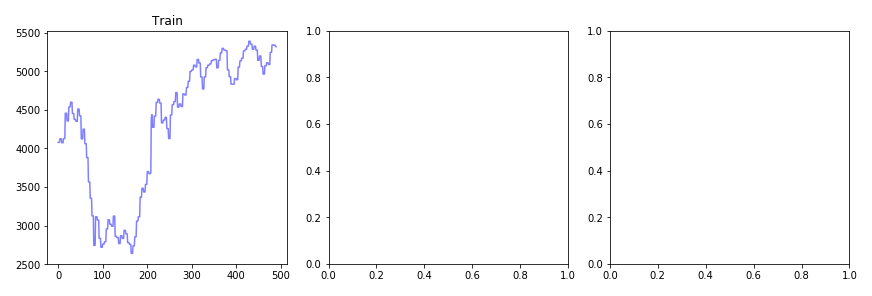

In [38]:
denoised_data_train = waveletSmooth(dict_dataframes_index['nifty 50 index data'][1][1].values);
denoised_data_validate = waveletSmooth(dict_dataframes_index['nifty 50 index data'][1][2].values);
denoised_data_test = waveletSmooth(dict_dataframes_index['nifty 50 index data'][1][3].values);


fig, axes= plt.subplots(1, 3,constrained_layout=True,figsize=(12,4))
axes[0].set_title('Train')
#axes[0].plot(denoised_data_train,'r',label='denoised train data');
axes[0].plot(dict_dataframes_index['nifty 50 index data'][1][1][1],'b',alpha=0.5, label='train data');

# axes[1].set_title('Validate')
# axes[1].plot(denoised_data_validate,'r',label='denoised validate data');
# axes[1].plot(dict_dataframes_index['nifty 50 index data'][1][2].values,'b',alpha=0.5,label='validate data');

# axes[2].set_title('Test')
# axes[2].plot(denoised_data_test,'r',label='denoised test data');
# axes[2].plot(dict_dataframes_index['nifty 50 index data'][1][3].values,'b',alpha=0.5,label='test data');
#plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())